## Background 

Climate analysis for precipitation and temperature in Hawaii  for last twelve months of data). Model the climate temperature normals and precipitation based on historical weather data. 


## Observable Trends 

* Hawaii had up to 7 inches of rain in last twelve months. Months with more than 3 inches of rain include: 
    * 2016- September, October 2016.
    * 2017- February, April, and July. 

* The most active station indicates the lowest temperature (54.0°F), highest temperature (85.0°F), and average (71.7°F) of the last twelve months. 

* The aggregate weather data helps us find the daily normals for the trip dates (07-01-2017 to 07-14-2017). 
* The visualization labeled `Aggregate Daily Normals for Trip Dates` shows the temperature extremes for the trip (low 60°F and high 88°F) while the average predicted temperatures stay in the mid 70's.

In [1]:
#Import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, DATE

In [3]:
#Create an engine instance
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [4]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [8]:
# Calculate the date 1 year ago from the last data point in the database

#Get the max date 
max_date=session.query(func.max(Measurement.date)).first()
max_date =max_date[0]

#Calculate the date 1 year ago from today. There are 365 days in a year
one_year_ago=dt.datetime.strptime(max_date, "%Y-%m-%d")-dt.timedelta(days=365)

In [9]:
# Perform a query to retrieve the data and precipitation scores
precipitations = session.query(Measurement.date,Measurement.prcp).\
            filter(Measurement.date >= one_year_ago).all()

In [10]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_data = pd.DataFrame(precipitations)

In [11]:
# Sort the dataframe by date
precipitation_data=precipitation_data.sort_values(by=['date'],ascending=True)
precipitation_data.head(5)

,date,prcp
0,2016-08-24,0.08
1006,2016-08-24,NaN
1524,2016-08-24,2.15
702,2016-08-24,2.28
360,2016-08-24,2.15


In [12]:
#Check null values in data set
precipitation_data.isnull().sum()

date      0
prcp    208
dtype: int64

In [13]:
#Replace all null values with 0 - Ideally expected but not doing it as there is no instruction to do so
#precipitation_data = precipitation_data.fillna(value=0)

In [14]:
#Check dataypes of df columns
precipitation_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2223 entries, 0 to 2222
Data columns (total 2 columns):
date    2223 non-null object
prcp    2015 non-null float64
dtypes: float64(1), object(1)
memory usage: 52.1+ KB


In [15]:
#Change data type of date to date
precipitation_data['date']= pd.to_datetime(precipitation_data['date'], format='%Y-%m-%d')

In [16]:
#Set index to date
precipitation_data.set_index('date', inplace=True)

In [17]:
#Sort dataframe by date
precipitation_data = precipitation_data.sort_values(by='date',ascending=True)

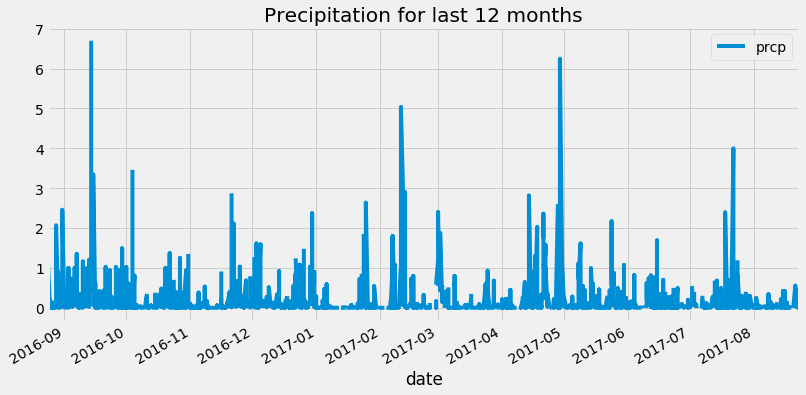

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_data.plot(figsize=(12,6), title="Precipitation for last 12 months")
plt.legend(loc='upper right')
plt.savefig("Images/Precipitation.png")
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_data.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [20]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(Measurement.station).distinct().count()
print(f"{station_count} uniuqe stations are available in this data set.")

9 uniuqe stations are available in this data set.


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations=session.query(Measurement.station,func.count(Measurement.tobs)).\
                group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Most active station - first one
print(f"Most active station is: {active_stations[0][0]}")

Most active station is: USC00519281


In [23]:
#Station with highest number of observations
active_station=active_stations[0][0]
active_station

'USC00519281'

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
low_tmp_station=session.query(Measurement.station,func.min(Measurement.tobs)).\
                filter(Measurement.station==active_station).\
                order_by(func.min(Measurement.tobs).asc()).first()
print(f"Lowest temp of {low_tmp_station[1]} degree was recorded at station {low_tmp_station[0]}")

Lowest temp of 54.0 degree was recorded at station USC00519281


In [25]:
# Highest temperature recorded, and average temperature of the most active station?
active_station_tmp=session.query(Measurement.station,func.max(Measurement.tobs),func.avg(Measurement.tobs),).\
                filter(Measurement.station==active_station).\
                group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()

print(f"Most Active Station {active_station_tmp[0]} Temperatures are:")
print(f"High Temperature: {active_station_tmp[1]}")
print(f"Average Temperature: {round(active_station_tmp[2],1)}")

Most Active Station USC00519281 Temperatures are:
High Temperature: 85.0
Average Temperature: 71.7


In [26]:
# Choose the station with the highest number of temperature observations.
high_tmp_station=session.query(Measurement.station,func.max(Measurement.tobs)).\
                filter(Measurement.station==active_station).\
                group_by(Measurement.station).order_by(func.max(Measurement.tobs).desc()).first()
print(f"Highest temp of {high_tmp_station[1]} degree was recorded at station {high_tmp_station[0]}")

Highest temp of 85.0 degree was recorded at station USC00519281


In [27]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
twelve_month_temp = session.query(Measurement.tobs).\
                filter(Measurement.station==active_station).\
                filter(Measurement.date >= one_year_ago).all()

#Check first five records
twelve_month_temp[:5]

[(77.0), (80.0), (80.0), (75.0), (73.0)]

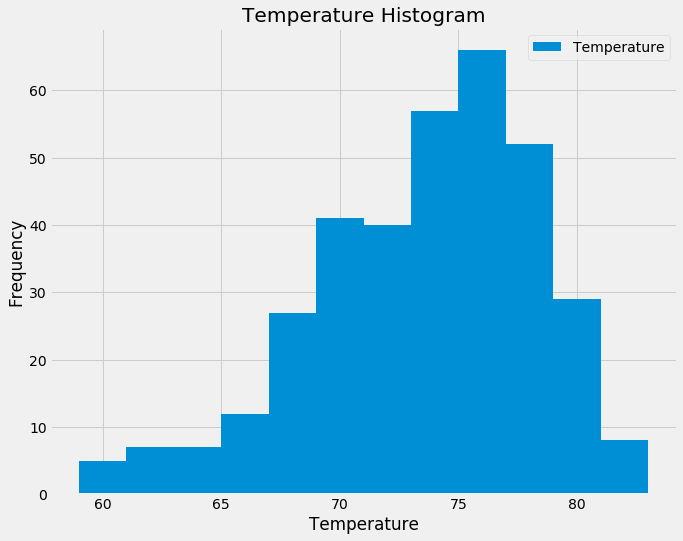

In [28]:
#Get average temp data set
temp_observations = pd.DataFrame(twelve_month_temp, columns=['Temperature'])

#Set bin size as 12
bins=12

#Plot histogram
temp_observations.plot.hist(bins=bins, title="Temperature Histogram",figsize=(10,8))

plt.xlabel("Temperature")
plt.ylabel("Frequency")

#Save chart
plt.savefig("Images/TempFrequency.png")

#Show chart
plt.show()

## Bonus Challenge Assignment

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps(one_year_ago,max_date)
trip

[(58.0, 74.57894736842105, 87.0)]

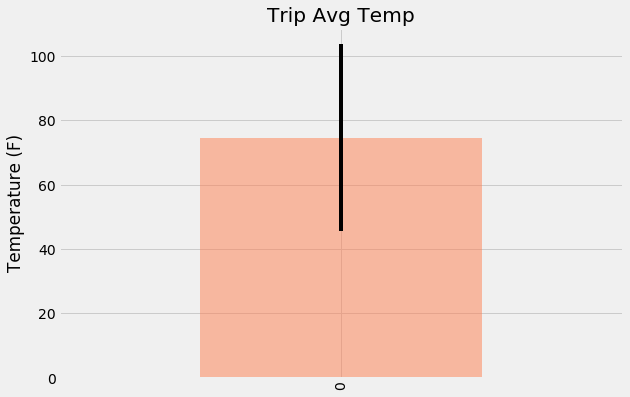

In [31]:
# Plot the results from your previous query as a bar chart. 
#Get data in to dataframe
trip_data = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])

# Use "Trip Avg Temp" as your Title
title="Trip Avg Temp"

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr=trip_data['tmax'] - trip_data['tmin']

#Plot chart
trip_data.plot.bar(y='tavg', yerr=yerr, title=title, color='coral', alpha=0.5, figsize=(9,6))

#plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temperature (F)")

plt.gca().legend_.remove()
plt.savefig("Images/TripAvgTemp.png")
plt.show()

In [32]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def calc_rainfall(start_date, end_date):
    
    """total rainfall for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        precipitation amount, station, name, latitude, longitude, and elevation in decending order
    """
    sel = [Station.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]

    return session.query(*sel).\
            filter(Measurement.station == Station.station).\
            filter(Measurement.date >= start_date).\
            filter(Measurement.date <= end_date).\
            group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

In [33]:
# function usage example
calc_rainfall = calc_rainfall(one_year_ago,max_date)
calc_rainfall_data=pd.DataFrame(calc_rainfall,columns=["Station","Name","Lat","Long","Ele","Prec"])
calc_rainfall_data

,Station,Name,Lat,Long,Ele,Prec
0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2.28
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.15
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.15
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.45
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,1.22
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.08
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip - taken from print statement
start_date="2017-07-01"
end_date = "2017-07-14"

# Use the start and end date to create a range of dates
date_range_data = session.query(Measurement.date).\
                  filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
                  group_by(Measurement.date).all()

# Stip off the year and save a list of %m-%d strings
date_range_list =[x[0][5:] for x in date_range_data]


#Get trip start and end month and dat
start_month_day= date_range_list[0]
end_month_day = date_range_list[-1]

# # Loop through the list of %m-%d strings and calculate the normals for each date
day_normals = session.query(func.strftime("%m-%d", Measurement.date),func.min(Measurement.tobs),func.round(func.avg(Measurement.tobs),1),func.max(Measurement.tobs)).\
              filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).\
              filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).\
              group_by(func.strftime("%m-%d", Measurement.date)).all()

print("Aggregate Daily Normals for 07-01 to 07-14")
day_normals

Aggregate Daily Normals for 07-01 to 07-14


[('07-01', 67.0, 74.8, 81.0),
 ('07-02', 68.0, 75.4, 82.0),
 ('07-03', 68.0, 75.3, 87.0),
 ('07-04', 70.0, 76.6, 81.0),
 ('07-05', 66.0, 75.0, 81.0),
 ('07-06', 69.0, 75.0, 81.0),
 ('07-07', 69.0, 74.9, 82.0),
 ('07-08', 69.0, 76.1, 83.0),
 ('07-09', 68.0, 76.2, 83.0),
 ('07-10', 68.0, 75.6, 82.0),
 ('07-11', 70.0, 75.8, 81.0),
 ('07-12', 67.0, 76.0, 82.0),
 ('07-13', 69.0, 76.2, 81.0),
 ('07-14', 61.0, 76.2, 82.0)]

In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
day_normals_data=pd.DataFrame(day_normals,columns=["Day-Month","Mini Temp","Avg Temp","Max Temp"])
day_normals_data["Date"]=[x[0] for x in date_range_data]
day_normals_data=day_normals_data[["Date","Mini Temp","Avg Temp","Max Temp"]]

#Set index
day_normals_data.set_index('Date',inplace=True)
day_normals_data

,Mini Temp,Avg Temp,Max Temp
Date,,,
2017-07-01,67.0,74.8,81.0
2017-07-02,68.0,75.4,82.0
2017-07-03,68.0,75.3,87.0
2017-07-04,70.0,76.6,81.0
2017-07-05,66.0,75.0,81.0
2017-07-06,69.0,75.0,81.0
2017-07-07,69.0,74.9,82.0
2017-07-08,69.0,76.1,83.0
2017-07-09,68.0,76.2,83.0


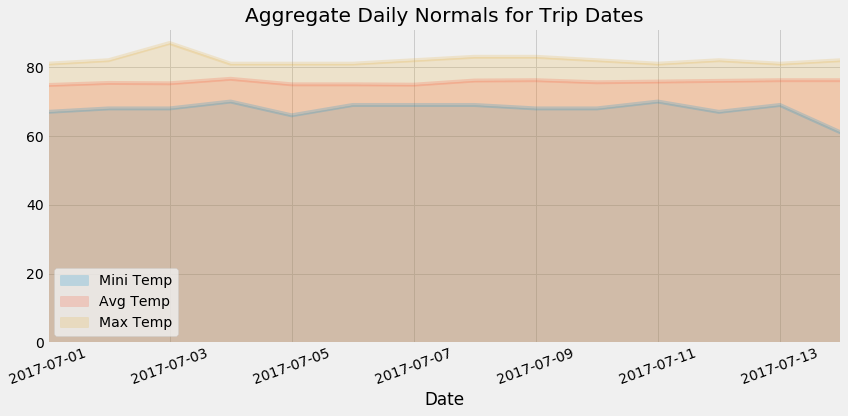

In [37]:
# Plot the daily normals as an area plot with `stacked=False`
ax= day_normals_data.plot.area(stacked=False,alpha=0.2,figsize=(12,6), title="Aggregate Daily Normals for Trip Dates")
ax.set_xlabel='Date'
ax.set_ylabel='Temperature'
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig("Images/DayNormals.png")
plt.show()